In [47]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score, get_scorer_names, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from xgboost import XGBClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from statistics import mode as md
from matplotlib import pyplot as plt
from IPython.display import clear_output, display_html 
from collections import Counter

In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [4]:
testing = pd.read_csv("tanzanian_water_wells/X_test.csv")
X = pd.read_csv("tanzanian_water_wells/X_train.csv")
y = pd.read_csv("tanzanian_water_wells/y_train.csv")['status_group'].map({'functional': 2, 'functional needs repair': 0, 'non functional': 1})

In [5]:
strategy = {1: 20000} #optional strategy
# smote=SMOTE(sampling_strategy=strategy)
smote = SMOTE()

In [6]:
#Dropping unecessary columns
X = X.drop(['id', 'wpt_name', 'subvillage', 'installer', 'funder', 'scheme_name', 'ward', 'date_recorded', 'recorded_by'], axis=1)
testing = testing.drop(['id', 'wpt_name', 'subvillage', 'installer', 'funder', 'scheme_name', 'ward', 'date_recorded', 'recorded_by'], axis=1)

# Eliminating null values from X_train
X.scheme_management.fillna("None", inplace=True)
X.permit.fillna('Unknown', inplace=True)
X.public_meeting.fillna('Unknown', inplace=True)

# Turning certain dtypes into others
X['permit'] = X['permit'].map({True: 'Yes', False: 'No', 'Unknown': 'Unknown'})
X['gps_height'] = X['gps_height'].astype('float64')
X['population'] = X['population'].astype('float64')
X['construction_year'] = X['construction_year'].astype('int64')
X['region_code'] = X['region_code'].astype('str')
X['district_code'] = X['district_code'].astype('str')

#Defining X_cat
X_cat = X.select_dtypes(exclude=['float64', 'int64'])
X_cat = X_cat.astype('str')
X_cat = pd.get_dummies(X_cat)

#Defining X_numeric
X_numeric = X.select_dtypes(['float64', 'int64'])
scaler = StandardScaler()
scaler.fit(X_numeric)
X_numeric = pd.DataFrame(scaler.transform(X_numeric), columns = X_numeric.columns, index = X_numeric.index)

#Defining X
X = pd.concat([X_numeric, X_cat], axis=1)

#Defining df
df = pd.concat([X, y], axis=1)

#Creating a train-test-split for X and y
X_train, X_test, y_train, y_test = train_test_split(X, y)

#Resampling dataframes for model creation
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_train_resampled = X_train_resampled.reset_index(drop=True)
y_train_resampled = y_train_resampled.reset_index(drop=True)
    
df_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)

#Separating concatenated dataframe into each status group
f = df_resampled[df_resampled.status_group == 0].reset_index(drop=True).copy()
nf = df_resampled[df_resampled.status_group == 2].reset_index(drop=True).copy()
fnr = df_resampled[df_resampled.status_group == 1].reset_index(drop=True).copy()

#Shuffling all the records
f = f.sample(frac=1)
nf = nf.sample(frac=1)
fnr = fnr.sample(frac=1)

#Splitting each status group into arrays of approximately 1,000 records
fs = [pd.DataFrame(i) for i in np.array_split(f, len(f)//1000)]
nfs = [pd.DataFrame(i) for i in np.array_split(nf, len(nf)//1000)]
fnrs = [pd.DataFrame(i) for i in np.array_split(fnr, len(fnr)//1000)]

#Creating our individual samples for models to train on
resamples = []
for i in range(len(fnrs)):
    resample = pd.concat([fs[i], nfs[i], fnrs[i]])
    resamples.append(resample)

In [7]:
estimators = {'Logistic Regression': LogisticRegression(solver='liblinear', fit_intercept=False), 
              'Decision Tree Classifier': DecisionTreeClassifier(), 
              'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=3), 
              'Bagging Classifier': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, max_features=50), 
              'Random Forest': RandomForestClassifier(), 
              'XG-Boost': XGBClassifier(), 
              'Adaboost': AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42), 
              'Gradient Boosted Trees': GradientBoostingClassifier(random_state=42, n_estimators=200, max_features=50), 
              'Extra Randomized Trees': ExtraTreesClassifier(n_estimators=100, random_state=42), 
              'Stacking Classifier': StackingClassifier(
        estimators = [('logistic_regression', LogisticRegression(solver='liblinear', fit_intercept=False)), 
                      ('bagging_classifier', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, max_features=50))], 
        final_estimator = XGBClassifier())}

In [59]:
estimator = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, max_features=50)

In [60]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, X_train, y_train, X_test, y_test):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model)
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
    return visualizer

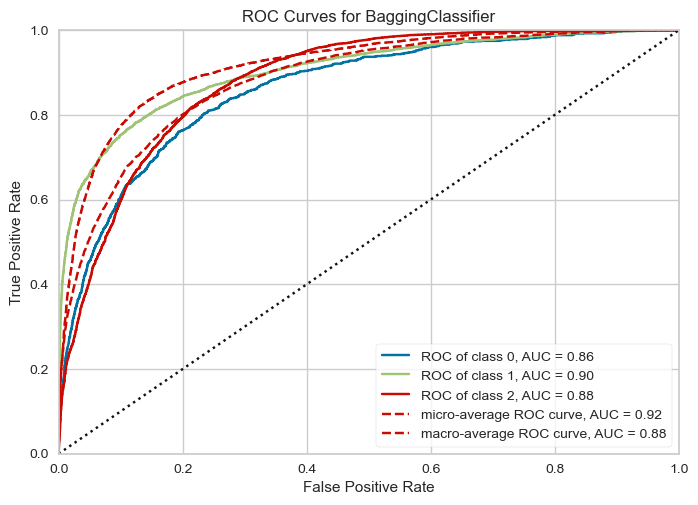

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for BaggingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=BaggingClassifier(estimator=DecisionTreeClassifier(),
                                   max_features=50, n_estimators=50))

In [61]:
plot_ROC_curve(estimator, X_train, y_train, X_test, y_test)